# **Comparison between the original and optimized Hotspot versions**

This notebook reproduces the figures present in Fig S1.

In [1]:
import harreman
import os
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
from scipy.stats import pearsonr, spearmanr, gaussian_kde
import random
from sklearn import linear_model
import pickle
from plotnine import *
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = '/home/projects/nyosef/oier/Harreman_files/Hotspot_tutorial_analysis'
DATA_PATH = os.path.join(BASE_PATH, 'data')
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

HOTSPOT_TUTO_DATA = '/home/projects/nyosef/oier/Hotspot_tutorial_data'

## Functions

In [2]:
def corr_plot(x, y, mean_expr, max_num=10000, outlier=0.01, line_on=True, method='spearman',
              legend_on=True, size=30, dot_color=None, outlier_color="r",
              alpha=0.8, color_rate=10, corr_on=None, colorbar=True, pmax=95, pmin=5):

    if method == 'pearson':
        score = pearsonr(x, y)
    if method == 'spearman':
        score = spearmanr(x, y)
    np.random.seed(0)
    if len(x) > max_num:
        idx = np.random.permutation(len(x))[:max_num]
        x, y = x[idx], y[idx]
        mean_expr = mean_expr[idx]
    outlier = int(len(x) * outlier)

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    idx1, idx2 = idx[outlier:], idx[:outlier]

    if dot_color is None:
        # c_score = np.log2(z[idx] + color_rate * np.min(z[idx]))
        c_score = mean_expr
    else:
        c_score = dot_color

    plt.set_cmap("Blues")
    vmax = np.percentile(c_score, pmax)
    vmin = np.percentile(c_score, pmin)
    plt.scatter(x, y, c=c_score, edgecolor=None, s=size, alpha=alpha, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar()
    # plt.scatter(x[idx2], y[idx2], c=outlier_color, edgecolor=None, s=size / 5,
    #             alpha=alpha / 3.0)

    if line_on:
        clf = linear_model.LinearRegression()
        clf.fit(x.reshape(-1, 1), y)
        xx = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        yy = clf.predict(xx)
        plt.plot(xx, yy, "k--", label="R=%.3f" % score[0])

    if legend_on or corr_on:
        plt.legend(loc="best", fancybox=True, ncol=1)

## Spatial data from Slide-seq

In [3]:
url = "https://github.com/YosefLab/scVI-data/blob/master/rodriques_slideseq.h5ad?raw=true"
adata = sc.read("rodriques_slideseq.h5ad", backup_url=url)
adata.obs["total_counts"] = np.asarray(adata.X.sum(1)).ravel()

adata.layers["csc_counts"] = adata.X.tocsc()

# renormalize the data for expression viz on plots
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.obsm['spatial'] = np.array(adata.obsm['spatial'])

### Running the optimized Hotspot version

In [4]:
harreman.tl.compute_knn_graph(adata, 
                           compute_neighbors_on_key="spatial", 
                           n_neighbors=300,
                           weighted_graph=False,
                           verbose=True)

Computing the neighborhood graph...
Computing the weights...
Finished computing the KNN graph in 3.312 seconds


In [5]:
harreman.hs.compute_local_autocorrelation(adata, layer_key="csc_counts", model='bernoulli', species='mouse', umi_counts_obs_key="total_counts", permutation_test=True)

Permutation test: 100%|██████████| 1000/1000 [23:18<00:00,  1.40s/it]


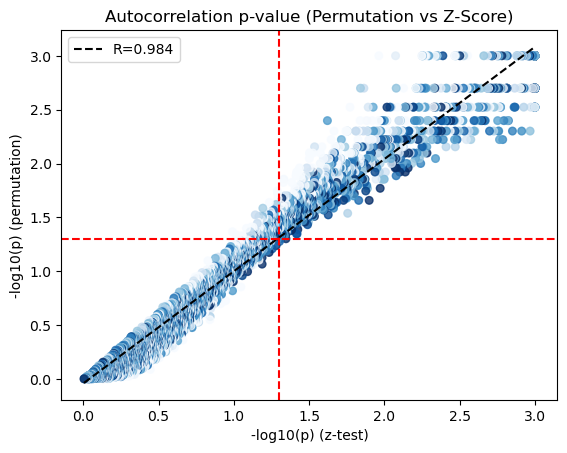

In [8]:
# global consistency
x = -np.log10(adata.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata.uns['gene_autocorrelation_results'].index

X = adata[:,genes].X.tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')
# plt.savefig(os.path.join(PLOTS_PATH, 'Spatial_p_np_autocorrelation_plot.pdf'))

In [9]:
hs_results = adata.uns['gene_autocorrelation_results']
hs_genes = hs_results.index[hs_results.Z_FDR < 0.05]

In [10]:
harreman.hs.compute_local_correlation(adata, genes=hs_genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 876 features...


Permutation test: 100%|██████████| 1000/1000 [10:27<00:00,  1.59it/s]


Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 630.758 seconds


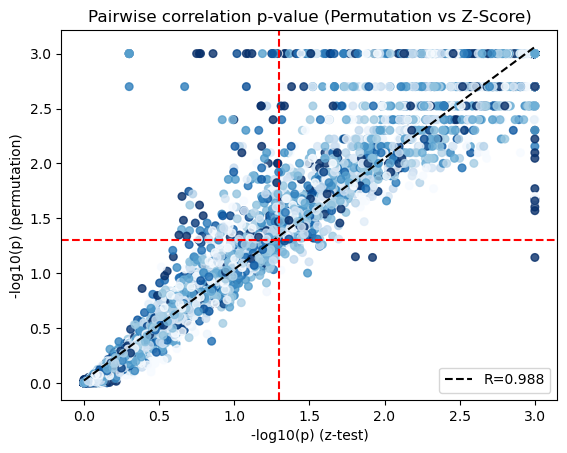

In [12]:
# global consistency
x = -np.log10(adata.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata.uns['lc_perm_pvals'].values).flatten()

genes = adata.uns['lc_z_pvals'].index

X = adata[:,genes].X.tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts

mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')
# plt.savefig(os.path.join(PLOTS_PATH, 'Spatial_p_np_correlation_plot.pdf'))

In [13]:
harreman.hs.create_modules(adata, min_gene_threshold=20, core_only=False, fdr_threshold=0.05)

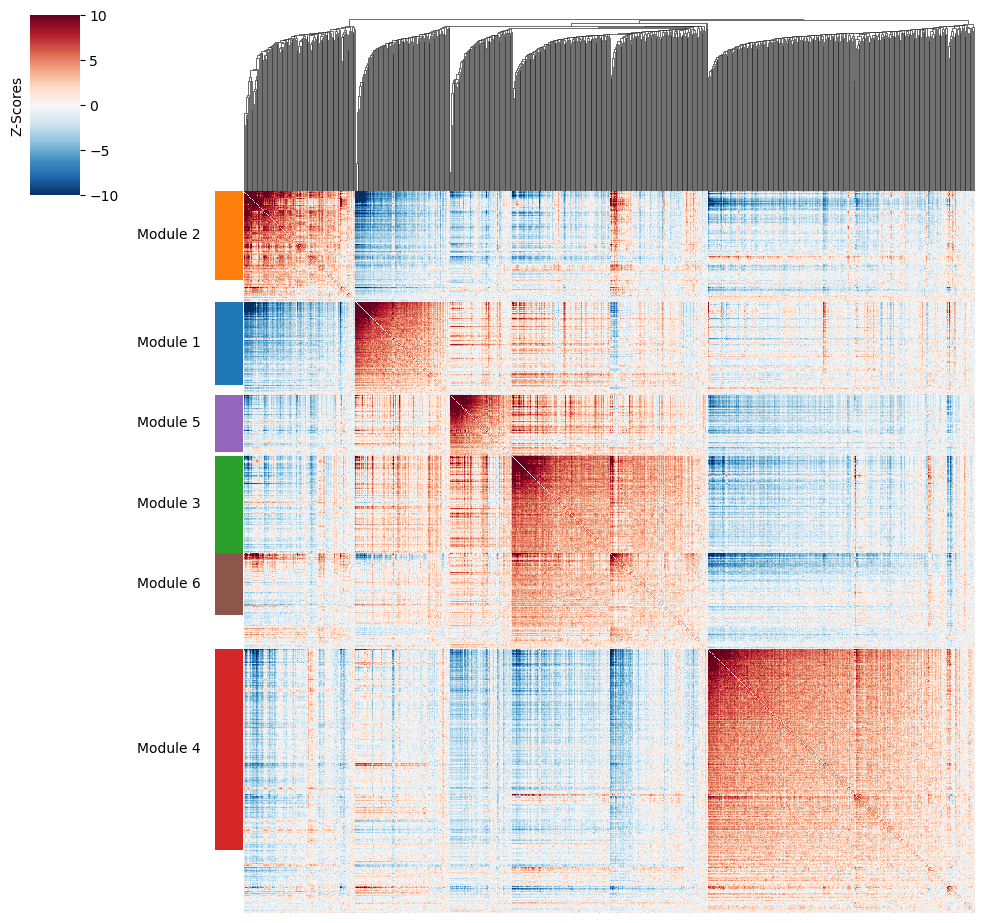

In [14]:
harreman.pl.local_correlation_plot(adata)

In [15]:
harreman.hs.calculate_module_scores(adata)

100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


In [16]:
modules = adata.obsm['module_scores'].columns
adata.obs[modules] = adata.obsm['module_scores']

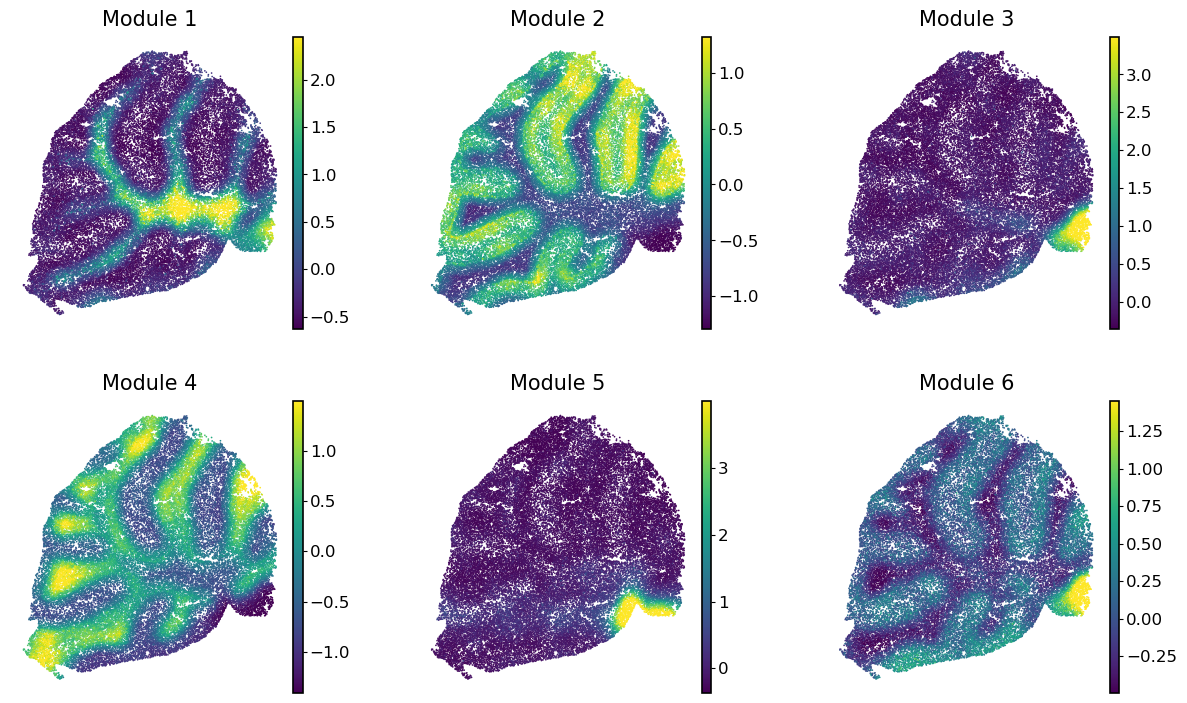

In [18]:
with mplscience.style_context():
    sc.pl.spatial(adata, color=modules, frameon=False, vmin="p1", vmax="p99", spot_size=30, ncols=3, cmap='viridis')

In [12]:
# harreman.write_h5ad(adata, os.path.join(ADATA_PATH, 'Hotspot_tuto_Spatial_harreman.h5ad'))

### Comparison with the original Hotspot algorithm

The *Fig_S1_Hotspot_analysis.py* script was used to run the code and save the files below.

In [ ]:
tutorial = 'Spatial'

In [ ]:
hs_results = pd.read_csv(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_tutorial_autocor_results.csv'), index_col=0)
lcz = pd.read_csv(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_tutorial_cor_results.csv'), index_col=0)
module_scores = pd.read_csv(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_tutorial_module_scores.csv'), index_col=0)

with open(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_hs_modules_dict.pkl'), 'rb') as f:
    hs_modules_dict = pickle.load(f)

In [ ]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, f'Hotspot_tuto_{tutorial}_harreman.h5ad'))
hs_fast_modules_dict = adata.uns['gene_modules']

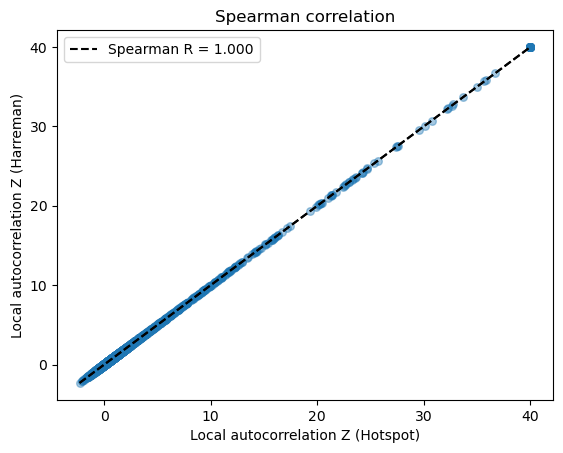

In [ ]:
# global consistency
x = hs_results.Z.values
y = adata.uns['gene_autocorrelation_results'].Z.values

lim = 40

x = np.where(x>lim, lim, x)
y = np.where(y>lim, lim, y)
x = np.where(x<-lim, -lim, x)
y = np.where(y<-lim, -lim, y)
corr_plot(x, y, method='spearman', alpha=0.4)
plt.xlabel('Local autocorrelation Z (Hotspot)')
plt.ylabel('Local autocorrelation Z (Harreman)')
plt.title('Spearman correlation')
# plt.savefig(os.path.join(PLOTS_PATH, f'Harreman_Hotspot_autocor_{tutorial}.pdf'))

In [ ]:
common_genes = adata.uns['lc_zs'].index.intersection(lcz.index)

harreman_common = adata.uns['lc_zs'].loc[common_genes, common_genes]
hotspot_common = lcz.loc[common_genes, common_genes]

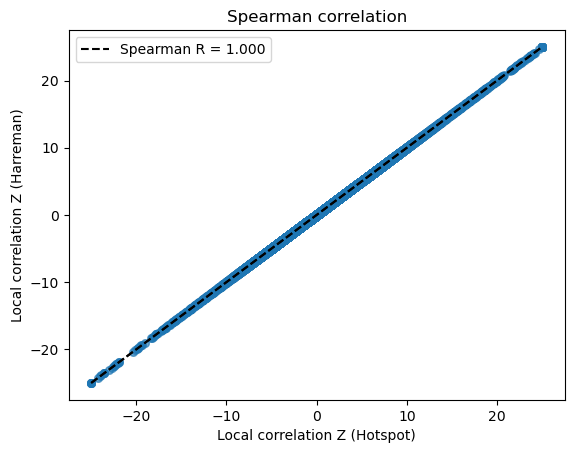

In [ ]:
# global consistency
x = hotspot_common.values.flatten()
y = harreman_common.values.flatten()

lim = 25

x = np.where(x>lim, lim, x)
y = np.where(y>lim, lim, y)
x = np.where(x<-lim, -lim, x)
y = np.where(y<-lim, -lim, y)
corr_plot(x, y, method='spearman', alpha=0.4)
plt.xlabel('Local correlation Z (Hotspot)')
plt.ylabel('Local correlation Z (Harreman)')
plt.title('Spearman correlation')
# plt.savefig(os.path.join(PLOTS_PATH, f'Harreman_Hotspot_cor_{tutorial}.svg'))

In [ ]:
sorted_keys = sorted(hs_fast_modules_dict.keys(), key=lambda x: int(x.split(' ')[-1]))
hs_fast_modules_dict = {key: hs_fast_modules_dict[key] for key in sorted_keys}

In [ ]:
hs_modules_dict = {key.split()[-1]: value for key, value in hs_modules_dict.items()}
hs_fast_modules_dict = {key.split(' ')[-1]: value for key, value in hs_fast_modules_dict.items()}

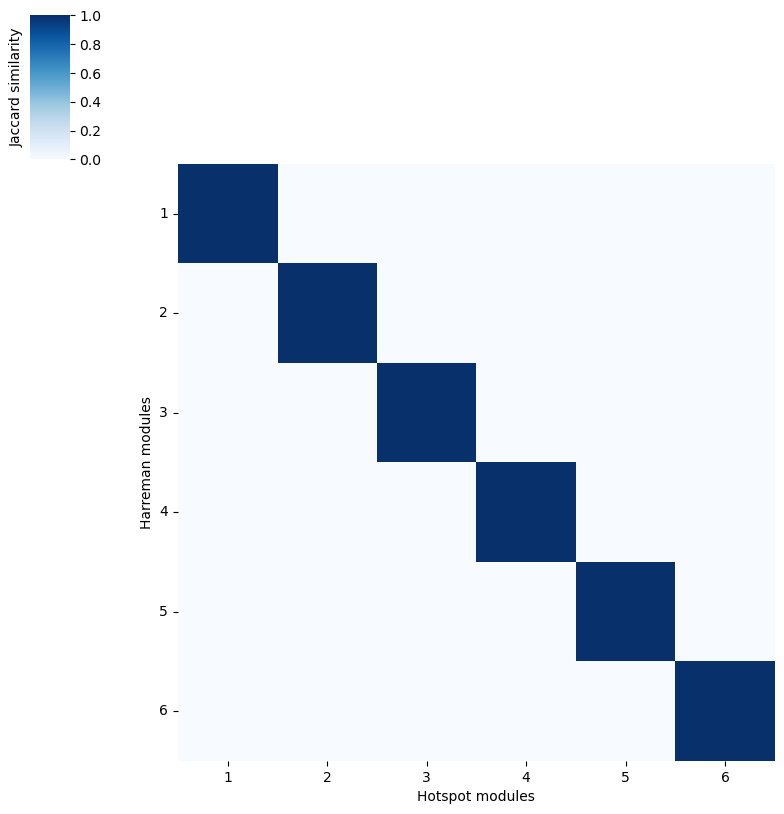

In [ ]:
jaccard_sim_matrix = np.zeros((len(hs_modules_dict.keys()), len(hs_fast_modules_dict.keys())))
for i in range(len(hs_modules_dict.keys())):
    for j in range(len(hs_fast_modules_dict.keys())):
        key_i = list(hs_modules_dict.keys())[i]
        key_j = list(hs_fast_modules_dict.keys())[j]
        a = hs_modules_dict[key_i]
        b = hs_fast_modules_dict[key_j]
        jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=hs_modules_dict.keys(), columns=hs_fast_modules_dict.keys()).T
cm = sns.clustermap(data=jaccard_sim_matrix_df, row_cluster=False, col_cluster=False, cmap='Blues', figsize=(8,8))
ax = cm.ax_heatmap
ax.set_xlabel('Hotspot modules')
ax.set_ylabel('Harreman modules')
# plt.yticks(rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_label_position("left")

fig = plt.gcf()

min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Jaccard similarity')
min_aa.yaxis.set_label_position("left")
# plt.savefig(os.path.join(PLOTS_PATH, f'Harreman_Hotspot_jaccard_{tutorial}.svg'))

In [ ]:
module_counts = pd.Series({key: len(value) for key, value in hs_modules_dict.items()}).reset_index().rename(columns={'index': 'Modules', 0: 'Count'})
module_counts.Modules = module_counts.Modules.astype('category')
modules_sorted = [str(i) for i in sorted(module_counts.Modules.cat.categories, key=lambda x: int(x))]
module_counts.Modules = module_counts.Modules.cat.reorder_categories(modules_sorted)
fig = (
    ggplot(module_counts, aes(x='Modules', y='Count')) 
    + geom_bar(stat='identity', fill='lightgrey') 
    + theme_classic() 
    + scale_y_continuous(labels=lambda l: ['{:,.0f}'.format(x) for x in l])
    + theme(plot_title = element_text(hjust = 0.5,
                                  margin={"t": 0, "b": 0, "l": 10, "r": 0},
                                  size = 11),
        legend_title = element_blank(),
        legend_text = element_text(size = 12),
        strip_text = element_text(size = 12),
        axis_title_x = element_blank(),
        axis_title_y = element_text(size = 14),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 12),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank(),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(5, 2)
        ) 
    + ylab('# Genes')

)
fig
# fig.save(os.path.join(PLOTS_PATH, f'Hotspot_n_genes_{tutorial}.svg'), format='svg')

/home/projects/nyosef/oier/mambaforge/envs/harreman-env/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 2 in image.
/home/projects/nyosef/oier/mambaforge/envs/harreman-env/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/projects/nyosef/oier/Harreman_files/Hotspot_tutorial_analysis/plots/Hotspot_n_genes_Spatial.svg


## Transcriptional Patterns in CD4 T Cells

In [19]:
mdata = mu.read_10x_h5(os.path.join(HOTSPOT_TUTO_DATA, "5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"))

In [20]:
mdata.var_names_make_unique()

In [21]:
adata = mdata.mod["rna"]

In [22]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

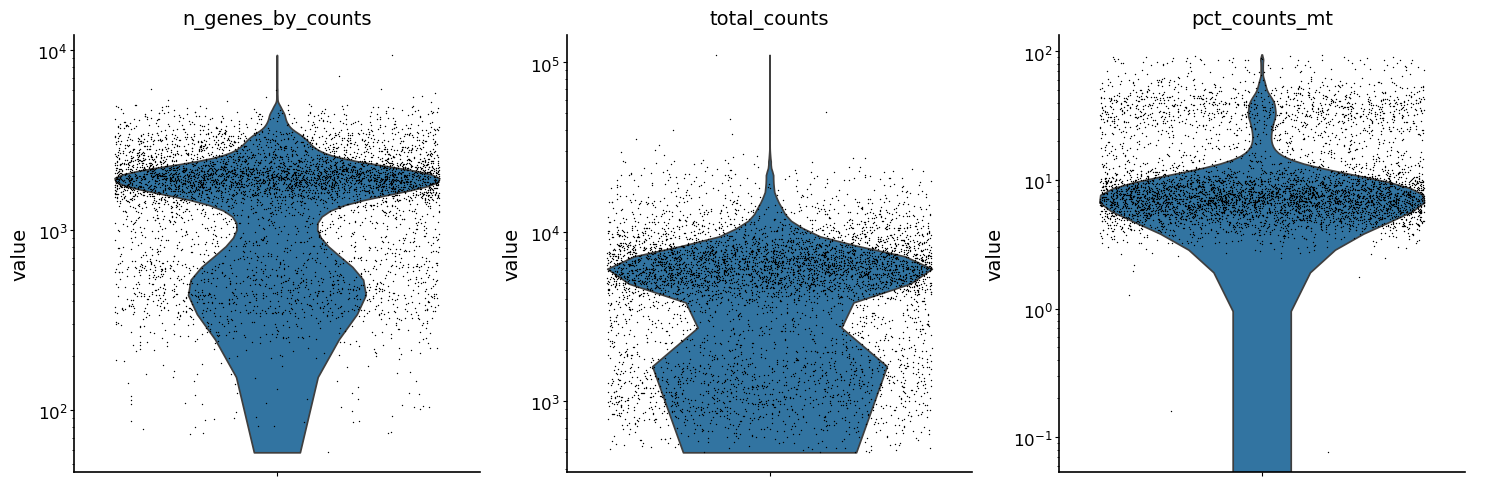

In [23]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True, log=True)

In [24]:
from muon import prot as pt
pt.pp.clr(mdata['prot'])

prot_data = mdata.mod["prot"]

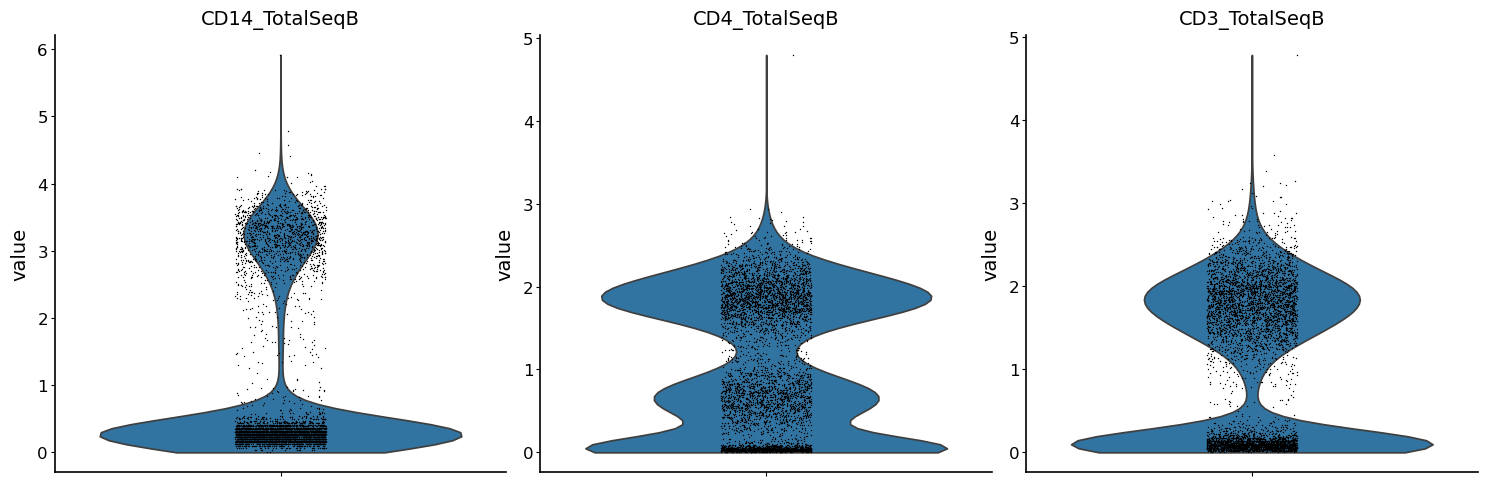

In [25]:
with mplscience.style_context():
    sc.pl.violin(prot_data, keys=["CD14_TotalSeqB", "CD4_TotalSeqB", "CD3_TotalSeqB"], multi_panel=True)

In [26]:
# now create a CD4 T cell mask
is_cd4 = np.asarray(
    (prot_data[:, 'CD14_TotalSeqB'].X.A < 2) &
    (prot_data[:, 'CD4_TotalSeqB'].X.A > 1) &
    (prot_data[:, 'CD3_TotalSeqB'].X.A > 1)
).ravel()

adata_cd4 = adata[is_cd4]
sc.pp.filter_cells(adata_cd4, min_genes=1000)
sc.pp.filter_genes(adata_cd4, min_cells=10)
adata_cd4 = adata_cd4[adata_cd4.obs.pct_counts_mt < 16].copy()

adata_cd4

AnnData object with n_obs × n_vars = 1547 × 12456
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [27]:
adata_cd4.layers["counts"] = adata_cd4.X.copy()
sc.pp.normalize_total(adata_cd4)
sc.pp.log1p(adata_cd4)
adata_cd4.layers["log_normalized"] = adata_cd4.X.copy()
sc.pp.scale(adata_cd4)
sc.tl.pca(adata_cd4)

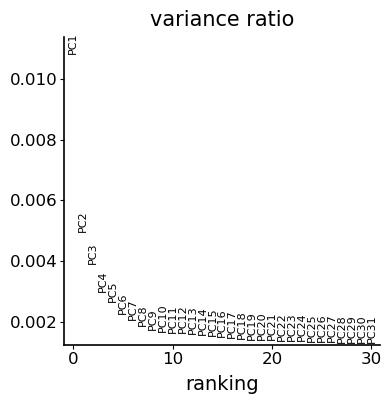

In [28]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata_cd4)

In [29]:
# rerun with fewer components
sc.tl.pca(adata_cd4, n_comps=10)

### Running the optimized Hotspot version

In [30]:
adata_cd4.layers["counts_csc"] = adata_cd4.layers["counts"].tocsc()

In [31]:
harreman.tl.compute_knn_graph(adata_cd4, 
                           compute_neighbors_on_key="X_pca", 
                           n_neighbors=30,
                           weighted_graph=False,
                           verbose=True)

Computing the neighborhood graph...
Computing the weights...
Finished computing the KNN graph in 0.050 seconds


In [32]:
harreman.hs.compute_local_autocorrelation(adata_cd4, layer_key="counts_csc", model='danb', umi_counts_obs_key="total_counts", permutation_test=True)

Permutation test: 100%|██████████| 1000/1000 [00:22<00:00, 44.52it/s]


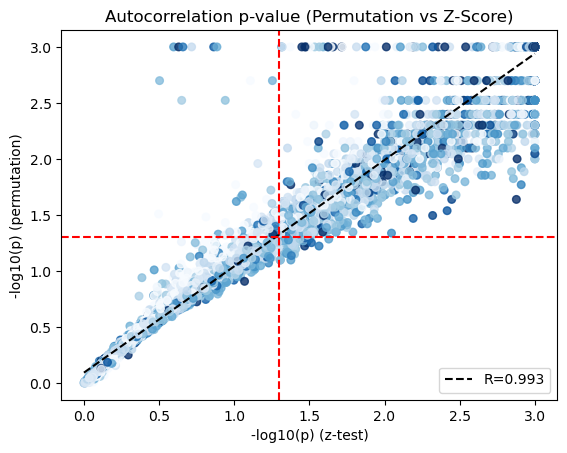

In [34]:
# global consistency
x = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata_cd4.uns['gene_autocorrelation_results'].index

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')
# plt.savefig(os.path.join(PLOTS_PATH, 'CD4_p_np_autocorrelation_plot.pdf'))

In [36]:
hs_results = adata_cd4.uns['gene_autocorrelation_results']
hs_genes = hs_results.loc[hs_results.Z_FDR < 0.05].sort_values('Z', ascending=False).head(500).index

In [37]:
harreman.hs.compute_local_correlation(adata_cd4, genes=hs_genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 500 features...


Permutation test:   0%|          | 0/1000 [00:00<?, ?it/s]

Permutation test: 100%|██████████| 1000/1000 [00:06<00:00, 156.02it/s]

Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 6.520 seconds


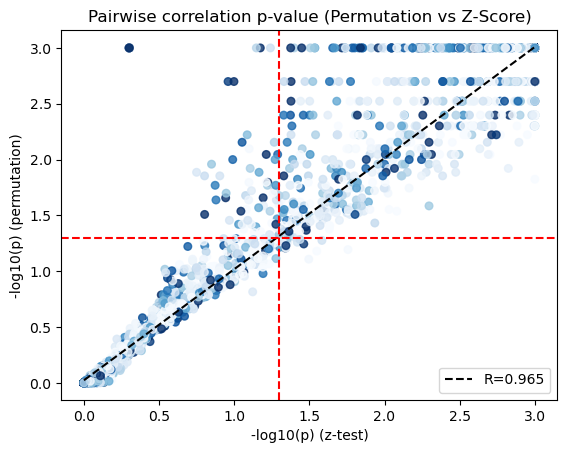

In [39]:
# global consistency
x = -np.log10(adata_cd4.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata_cd4.uns['lc_perm_pvals'].values).flatten()

genes = adata_cd4.uns['lc_z_pvals'].index
# mean_expr = adata_cd4[:,genes].layers['log_normalized'].mean(axis=0).A1

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts

mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')
plt.savefig(os.path.join(PLOTS_PATH, 'CD4_p_np_correlation_plot.pdf'))

In [40]:
harreman.hs.create_modules(adata_cd4, min_gene_threshold=15, core_only=True, fdr_threshold=0.05)

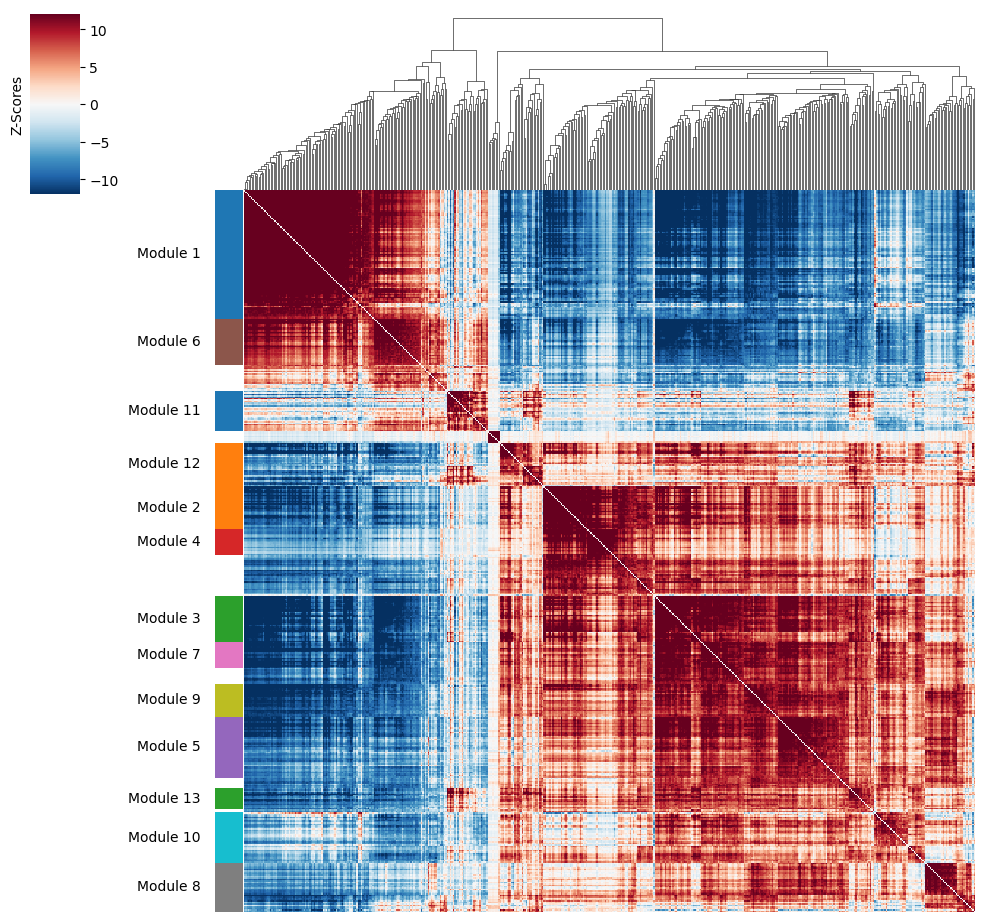

In [41]:
harreman.pl.local_correlation_plot(adata_cd4, vmin=-12, vmax=12)

In [42]:
harreman.hs.calculate_module_scores(adata_cd4)

100%|██████████| 13/13 [00:00<00:00, 35.99it/s]


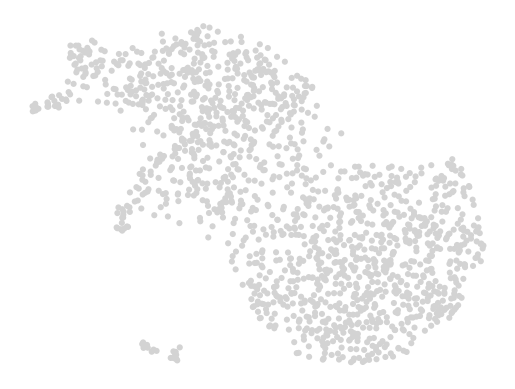

In [43]:
sc.pp.neighbors(adata_cd4)
sc.tl.umap(adata_cd4)
sc.pl.umap(adata_cd4, frameon=False)

In [44]:
modules = adata_cd4.obsm['module_scores'].columns
adata_cd4.obs[modules] = adata_cd4.obsm['module_scores']

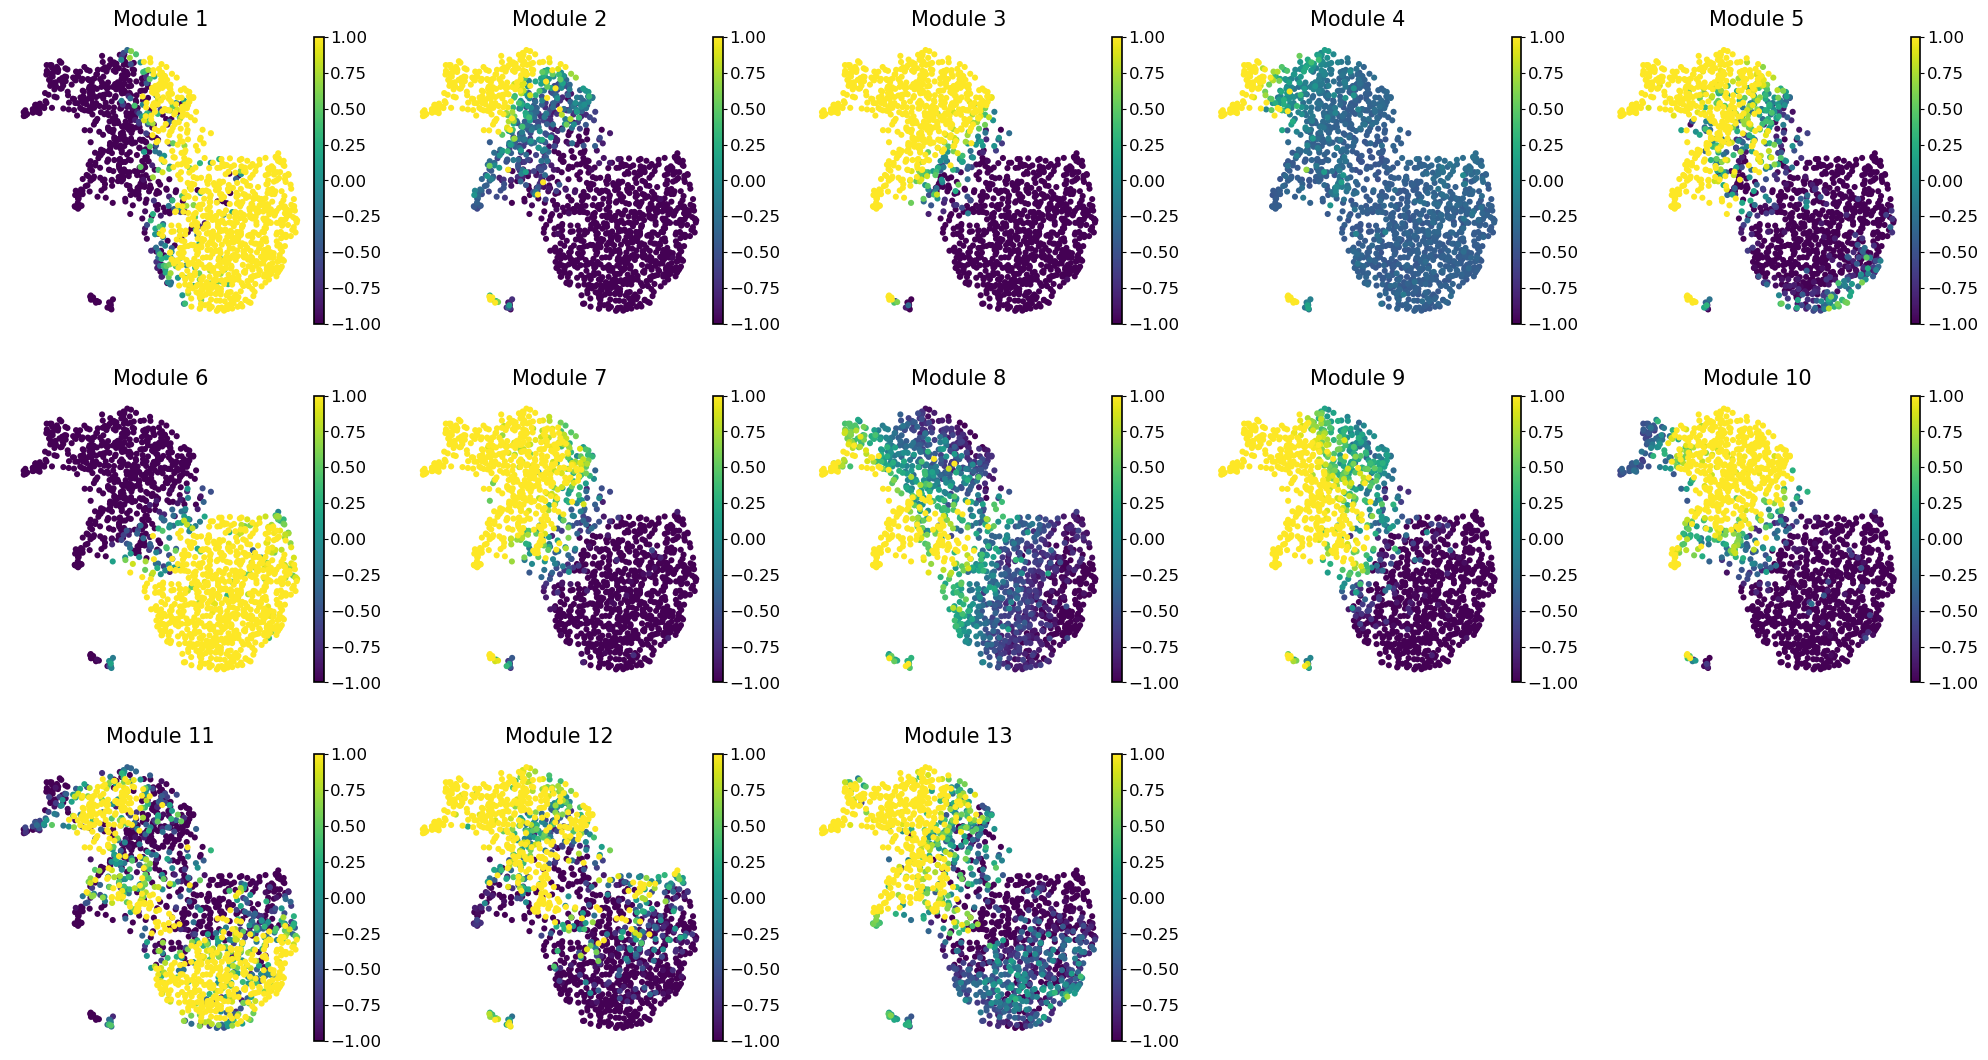

In [46]:
with mplscience.style_context():
    sc.pl.umap(adata_cd4, color=modules, frameon=False, vmin="-1", vmax="1", ncols=5, cmap='viridis')

In [37]:
# harreman.write_h5ad(adata_cd4, os.path.join(ADATA_PATH, 'Hotspot_tuto_CD4_harreman.h5ad'))

### Comparison with the original Hotspot algorithm

The *Fig_S1_Hotspot_analysis.py* script was used to run the code and save the files below.

In [ ]:
tutorial = 'CD4'

In [ ]:
hs_results = pd.read_csv(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_tutorial_autocor_results.csv'), index_col=0)
lcz = pd.read_csv(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_tutorial_cor_results.csv'), index_col=0)
module_scores = pd.read_csv(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_tutorial_module_scores.csv'), index_col=0)

with open(os.path.join(DATA_PATH, f'Hotspot_{tutorial}_hs_modules_dict.pkl'), 'rb') as f:
    hs_modules_dict = pickle.load(f)

In [ ]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, f'Hotspot_tuto_{tutorial}_harreman.h5ad'))
hs_fast_modules_dict = adata.uns['gene_modules']

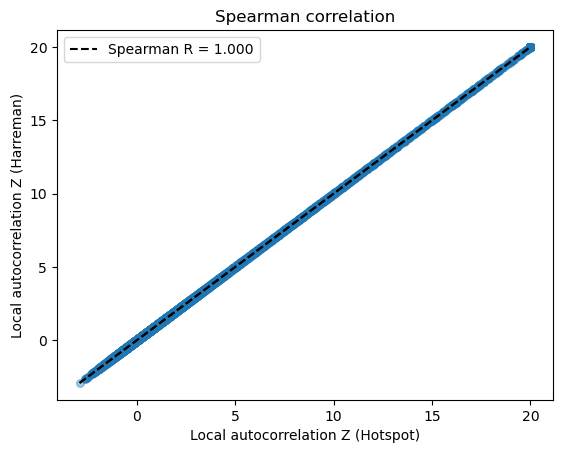

In [ ]:
# global consistency
x = hs_results.Z.values
y = adata.uns['gene_autocorrelation_results'].Z.values

x = np.where(x>20, 20, x)
y = np.where(y>20, 20, y)
x = np.where(x<-20, -20, x)
y = np.where(y<-20, -20, y)
corr_plot(x, y, method='spearman', alpha=0.4)
plt.xlabel('Local autocorrelation Z (Hotspot)')
plt.ylabel('Local autocorrelation Z (Harreman)')
plt.title('Spearman correlation')
# plt.savefig(os.path.join(PLOTS_PATH, f'Harreman_Hotspot_autocor_{tutorial}.svg'))

In [ ]:
common_genes = adata.uns['lc_zs'].index.intersection(lcz.index)

harreman_common = adata.uns['lc_zs'].loc[common_genes, common_genes]
hotspot_common = lcz.loc[common_genes, common_genes]

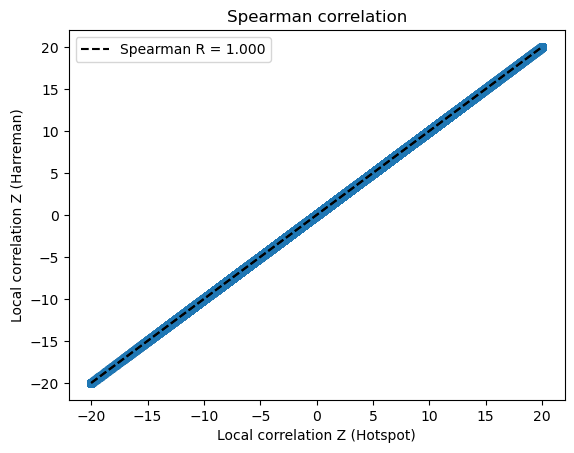

In [ ]:
# global consistency
x = hotspot_common.values.flatten()
y = harreman_common.values.flatten()

x = np.where(x>20, 20, x)
y = np.where(y>20, 20, y)
x = np.where(x<-20, -20, x)
y = np.where(y<-20, -20, y)
corr_plot(x, y, method='spearman', alpha=0.4)
plt.xlabel('Local correlation Z (Hotspot)')
plt.ylabel('Local correlation Z (Harreman)')
plt.title('Spearman correlation')
# plt.savefig(os.path.join(PLOTS_PATH, f'Harreman_Hotspot_cor_{tutorial}.svg'))

In [ ]:
sorted_keys = sorted(hs_fast_modules_dict.keys(), key=lambda x: int(x.split(' ')[-1]))
hs_fast_modules_dict = {key: hs_fast_modules_dict[key] for key in sorted_keys}

In [ ]:
hs_modules_dict = {key.split()[-1]: value for key, value in hs_modules_dict.items()}
hs_fast_modules_dict = {key.split(' ')[-1]: value for key, value in hs_fast_modules_dict.items()}

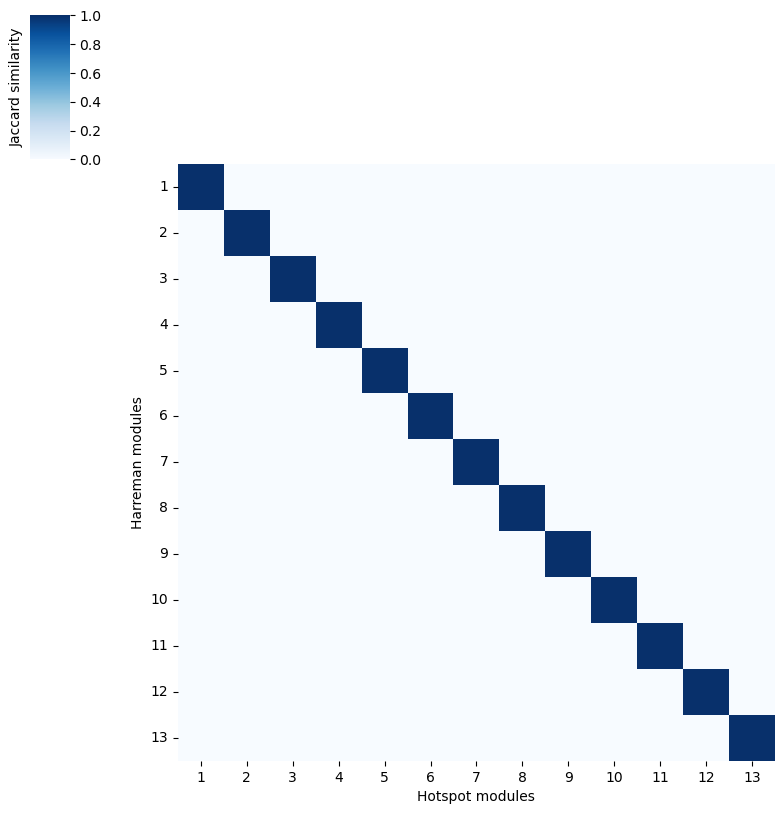

In [ ]:
jaccard_sim_matrix = np.zeros((len(hs_modules_dict.keys()), len(hs_fast_modules_dict.keys())))
for i in range(len(hs_modules_dict.keys())):
    for j in range(len(hs_fast_modules_dict.keys())):
        key_i = list(hs_modules_dict.keys())[i]
        key_j = list(hs_fast_modules_dict.keys())[j]
        a = hs_modules_dict[key_i]
        b = hs_fast_modules_dict[key_j]
        jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=hs_modules_dict.keys(), columns=hs_fast_modules_dict.keys()).T
cm = sns.clustermap(data=jaccard_sim_matrix_df, row_cluster=False, col_cluster=False, cmap='Blues', figsize=(8,8))
ax = cm.ax_heatmap
ax.set_xlabel('Hotspot modules')
ax.set_ylabel('Harreman modules')
# plt.yticks(rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_label_position("left")

fig = plt.gcf()

min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Jaccard similarity')
min_aa.yaxis.set_label_position("left")
# plt.savefig(os.path.join(PLOTS_PATH, f'Harreman_Hotspot_jaccard_{tutorial}.svg'))

In [ ]:
module_counts = pd.Series({key: len(value) for key, value in hs_modules_dict.items()}).reset_index().rename(columns={'index': 'Modules', 0: 'Count'})
module_counts.Modules = module_counts.Modules.astype('category')
modules_sorted = [str(i) for i in sorted(module_counts.Modules.cat.categories, key=lambda x: int(x))]
module_counts.Modules = module_counts.Modules.cat.reorder_categories(modules_sorted)
fig = (
    ggplot(module_counts, aes(x='Modules', y='Count')) 
    + geom_bar(stat='identity', fill='lightgrey') 
    + theme_classic() 
    + scale_y_continuous(labels=lambda l: ['{:,.0f}'.format(x) for x in l])
    + theme(plot_title = element_text(hjust = 0.5,
                                  margin={"t": 0, "b": 0, "l": 10, "r": 0},
                                  size = 11),
        legend_title = element_blank(),
        legend_text = element_text(size = 12),
        strip_text = element_text(size = 12),
        axis_title_x = element_blank(),
        axis_title_y = element_text(size = 14),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 12),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank(),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(5, 2)
        ) 
    + ylab('# Genes')

)
fig
# fig.save(os.path.join(PLOTS_PATH, f'Hotspot_n_genes_{tutorial}.svg'), format='svg')

/home/projects/nyosef/oier/mambaforge/envs/harreman-env/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 2 in image.
/home/projects/nyosef/oier/mambaforge/envs/harreman-env/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /home/projects/nyosef/oier/Harreman_files/Hotspot_tutorial_analysis/plots/Hotspot_n_genes_CD4.svg


## Runtime comparison

### Different dataset sizes

The *Fig_S1_Hotspot_analysis.py* and the *Fig_S1_Harreman_runtime_analysis.py* scripts were used to run the code and save the files below.

In [ ]:
with open(os.path.join(DATA_PATH, 'Hotspot_runtime_dict.pkl'), 'rb') as f:
    hs_runtime_dict = pickle.load(f)
    
with open(os.path.join(DATA_PATH, 'Harreman_runtime_dict.pkl'), 'rb') as f:
    runtime_dict = pickle.load(f)

In [ ]:
runtime_dict['Hotspot'] = hs_runtime_dict['Hotspot']

In [ ]:
dataset_sizes = {
    'Spatial': 32701,
    'Spatial_subset': 14309,
    'CD4': 1547,
    'Lineage': 1756,
}

In [ ]:
runtime_dict

{'Harreman (CPU)': {'Spatial': 244.9362895488739,
  'Spatial_subset_1': 142.36095118522644,
  'Spatial_subset_2': 96.35280537605286,
  'CD4': 3.2933008670806885},
 'Harreman (GPU)': {'Spatial': 18.411730527877808,
  'Spatial_subset_1': 10.244361639022827,
  'Spatial_subset_2': 6.323671102523804,
  'CD4': 0.5927140712738037},
 'Hotspot': {'Spatial': 3018.697207212448,
  'Spatial_subset_1': 2408.9544546604156,
  'Spatial_subset_2': 1322.0575308799744,
  'CD4': 10.848909616470337}}

In [ ]:
runtime_df = pd.DataFrame.from_dict(runtime_dict).reset_index().rename(columns={'index': 'Tutorial'})
runtime_melt_df = pd.melt(runtime_df, id_vars=['Tutorial'], value_vars=['Harreman (CPU)', 'Harreman (GPU)', 'Hotspot']).rename(columns={'variable': 'Method', 'value': 'Runtime (s)'}).dropna()

In [ ]:
datasets = ['CD4', 'Spatial_subset_2', 'Spatial_subset_1', 'Spatial']
methods = ['Hotspot', 'Harreman (CPU)', 'Harreman (GPU)']

In [ ]:
runtime_melt_df.Method = runtime_melt_df.Method.astype('category')
runtime_melt_df.Method = runtime_melt_df.Method.cat.reorder_categories(methods)

runtime_melt_df.Tutorial = runtime_melt_df.Tutorial.astype('category')
runtime_melt_df.Tutorial = runtime_melt_df.Tutorial.cat.reorder_categories(datasets)

In [ ]:
runtime_dict = {
    outer_key: {key: inner_dict[key] for key in datasets} 
    for outer_key, inner_dict in runtime_dict.items()
}

In [ ]:
colors = ['#A6CEE3', '#3288BD', "#08306B"]

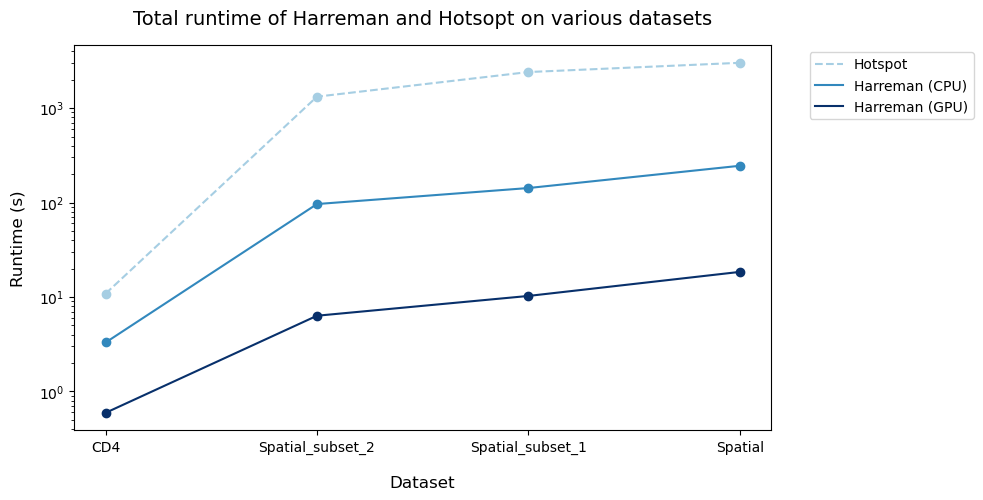

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))

x_positions = np.arange(len(datasets)) - 0.25
idx = 0

for i, method in enumerate(methods):
    runtime = runtime_dict[method]
    linestyle = 'dashed' if method == 'Hotspot' else 'solid'
    ax.plot(np.arange(len(runtime.keys())), list(runtime.values()), label=method, color=colors[i], linestyle=linestyle)
    ax.scatter(np.arange(len(runtime.keys())), list(runtime.values()), color=colors[i])
    idx += 1

ax.set_xticks(np.arange(len(datasets)), datasets)
ax.set_xlabel('Dataset', fontsize=12, labelpad=15)
ax.set_ylabel('Runtime (s)', fontsize=12, labelpad=10)
ax.set_title('Total runtime of Harreman and Hotsopt on various datasets', fontsize=14, pad=15)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
ax.set_yscale('log')

# plt.savefig(os.path.join(PLOTS_PATH, 'Harreman_Hotspot_runtime.svg'), bbox_inches='tight')
plt.show()

### Different number of genes

The *Fig_S1_Hotspot_n_genes_analysis.py* and the *Fig_S1_Harreman_n_genes_runtime_analysis.py* scripts were used to run the code and save the files below.

In [ ]:
with open(os.path.join(DATA_PATH, 'Hotspot_runtime_n_genes_dict.pkl'), 'rb') as f:
    hs_runtime_dict = pickle.load(f)

with open(os.path.join(DATA_PATH, 'Harreman_runtime_n_genes_dict.pkl'), 'rb') as f:
    runtime_dict = pickle.load(f)

In [ ]:
runtime_dict['Hotspot'] = hs_runtime_dict['Hotspot']

In [ ]:
runtime_dict

{'Harreman (CPU)': {200: 219.60160541534424,
  400: 236.41552329063416,
  600: 246.36112117767334,
  800: 261.7568600177765},
 'Harreman (GPU)': {200: 16.37363600730896,
  400: 16.12171173095703,
  600: 17.912604808807373,
  800: 18.110294103622437},
 'Hotspot': {200: 797.8856191635132,
  400: 2399.4920637607574,
  600: 4494.38166475296,
  800: 6993.753687143326}}

In [ ]:
runtime_df = pd.DataFrame.from_dict(runtime_dict).reset_index().rename(columns={'index': 'Number of genes'})
runtime_melt_df = pd.melt(runtime_df, id_vars=['Number of genes'], value_vars=['Harreman (CPU)', 'Harreman (GPU)', 'Hotspot']).rename(columns={'variable': 'Method', 'value': 'Runtime (s)'}).dropna()

In [ ]:
n_genes = [200, 400, 600, 800]
methods = ['Hotspot', 'Harreman (CPU)', 'Harreman (GPU)']

In [ ]:
runtime_melt_df.Method = runtime_melt_df.Method.astype('category')
runtime_melt_df.Method = runtime_melt_df.Method.cat.reorder_categories(methods)

runtime_melt_df['Number of genes'] = runtime_melt_df['Number of genes'].astype('category')
runtime_melt_df['Number of genes'] = runtime_melt_df['Number of genes'].cat.reorder_categories(n_genes)

In [ ]:
colors = ['#A6CEE3', '#3288BD', "#08306B"]

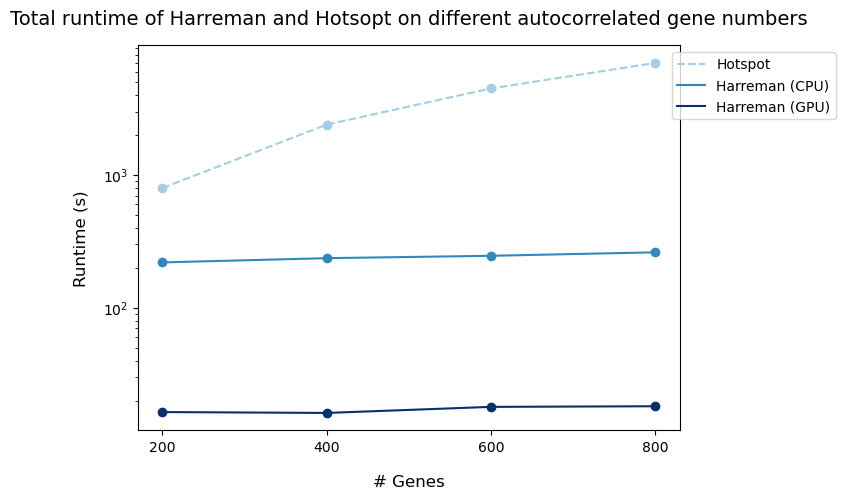

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

x_positions = np.arange(len(n_genes)) - 0.25
idx = 0

for i, method in enumerate(methods):
    runtime = runtime_dict[method]
    linestyle = 'dashed' if method == 'Hotspot' else 'solid'
    ax.plot(np.arange(len(runtime.keys())), list(runtime.values()), label=method, color=colors[i], linestyle=linestyle)
    ax.scatter(np.arange(len(runtime.keys())), list(runtime.values()), color=colors[i])
    idx += 1

ax.set_xticks(np.arange(len(n_genes)), n_genes)
ax.set_xlabel('# Genes', fontsize=12, labelpad=15)
ax.set_ylabel('Runtime (s)', fontsize=12, labelpad=10)
ax.set_title('Total runtime of Harreman and Hotsopt on different autocorrelated gene numbers', fontsize=14, pad=15)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
ax.set_yscale('log')

# plt.savefig(os.path.join(PLOTS_PATH, 'Harreman_Hotspot_n_genes_runtime.svg'), bbox_inches='tight')
plt.show()